In [1]:
## Import libraries ##
import numpy as np
import math
from scipy import stats
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import pandas as pd

In [2]:
## Define basic functions ##

#generate points that aren't too close to each other
def generate_points(minX, maxX, N, min_distance = 0.05, dim = 1):
    points = []
    while len(points) < N:
        # Generate a random point
        point = np.random.uniform(-5, 5, size=(2,dim)) # Adjust range as needed
        if len(points) == 0:
            points.append(point)
        else:
            # Check distance with existing points
            valid_point = True
            for existing_point in points:
                distance = np.linalg.norm(point - existing_point)
                if distance < min_distance:
                    valid_point = False
                    break
            if valid_point:
                points.append(point)
    return np.concatenate(points)


#squared expo kernel
def kernel(Xp, Xq, l1, l2, l1l2, sigma):
    '''
    l is DxD matrix. Ex: l = [[1,0],[0,1]]
    '''
    kern_row = []
    for xi in Xp:
        kern_col = []
        for xj in Xq:
            l = [[1/l1**2,l1l2],[l1l2,1/l2**2]]
            M = np.asarray(l)
            quad = np.dot((xi-xj),np.dot(M,(xi-xj).T)) #quadratic term
            kern_col.append(quad)
        kern_row.append(kern_col)
    kern_row = np.asarray(kern_row)
    sqexpo = (sigma**2)*np.exp(-.5*kern_row)
    return sqexpo


#squared expo kernel
def kernel_old(a, b, kernelParameter_l, kernelParameter_sigma):
    #Hyperparameters:
    #kernelParameter_l = 1.94 #0.3 #1.94
    #kernelParameter_sigma = 1.75 #1.0 #1.75
    
    #Kernel:
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    sqexpo = (kernelParameter_sigma**2)*np.exp(-.5 * (1/(kernelParameter_l**2)) * sqdist)
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return sqexpo


# Known: (X,y) observations. Hyperparameters in covar funct K+sI include sigma_n, l, and sigma
def posterior(X, y, sigma_n, l1, l2, l1l2, sigma, dim = 2):
    '''
    Args:
        X: Training features (N x dim)
        y: Training targets (N x 1)
        hyperparameters
        
    Returns:
        Xtest: new input locations used (n x dim)
        mu: posterior mean vector (n x 1)
        std: posterior std (n x 1)
    '''
    N = len(X) #in one dim
    n = 20 #in one dim
    step = np.abs(np.max(X) - np.min(X))/n # step size for Xtest
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, l1, l2, l1l2, sigma)
    #K.shape = (N x N)
    L = np.linalg.cholesky(K + (sigma_n**2)*np.eye(N))
    #L.shape = (N x N)

    ## 3) Predictive mean at test points
    r = []
    for i in range(dim):
        rx_i = np.arange(np.min(X), np.max(X), step)
        r.append(rx_i)
    r = np.array(r)
    g = np.array(np.meshgrid(*r))
    g_ravel = []
    for i in range(len(g)):
        g_ravel.append(g[i].ravel())
    g_ravel = np.array(g_ravel)
    Xtest = np.c_[g_ravel.T] #np.c_ : [[x1,x2,etc.],[y1,y2,etc.]] --> [[x1,y1],[x2,y2],etc.]
    #Xtest.shape = (n x dim)
    
    v = np.linalg.solve(L, kernel(X, Xtest, l1, l2, l1l2, sigma))   #v = L^{-1} k_*
    #v.shape = (N x n)
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    #b.shape = (N x 1)
    mu = np.dot(v.T, b) #f_* = v^Tb
    #mu.shape = (n x 1)

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, l1, l2, l1l2, sigma) #this is a diag mat since x_p = x_q in k(x_p,x_q) 
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    #sigma.shape = (n x n)
    var = np.diag(sigma)
    std = np.sqrt(np.abs(var))
    
    return g, Xtest, mu, std


#Given test point x (Xtest_val), what is y?
def conditional(Xtest_val, X, y, sigma_n, l1, l2, l1l2, sigma):
    '''
    conditional(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Given test point x (Xtest_val), what is y?
    '''
    N = len(X)
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, l1, l2, l1l2, sigma)
    #K.shape = (N x N)
    L = np.linalg.cholesky(K + (sigma_n**2)*np.eye(N))
    #L.shape = (N x N)

    ## 3) Predictive mean at test points
    Xtest = np.asarray(Xtest_val)
    v = np.linalg.solve(L, kernel(X, Xtest, l1, l2, l1l2, sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, l1, l2, l1l2, sigma) #this is a diagonal matrix since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    var = np.diag(sigma)
    std = np.sqrt(np.abs(var))

    return Xtest_val, mu, std

    
def plot_2D(X, y, sigma_n, l1, l2, l1l2, sigma):
    '''
    Only use when X is 2D
    '''
    g, Xtest, mu, std = posterior(X, y, sigma_n, l1, l2, l1l2, sigma, dim = 2)

    ##Render plots
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Plot predictive mean
    gx1, gx2 = g[0], g[1]

    #Render plots
    surf = ax.plot_surface(gx1, gx2, mu.reshape(gx1.shape), cmap=cm.coolwarm,
                           linewidth=0, antialiased=False, alpha = 0.3)

    #Plot training data
    ax.scatter(X[:,0], X[:,1], y, c = y, marker = 'o', cmap=cm.coolwarm)
    
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

## Given

Text(0.5, 0.5, 'X2')

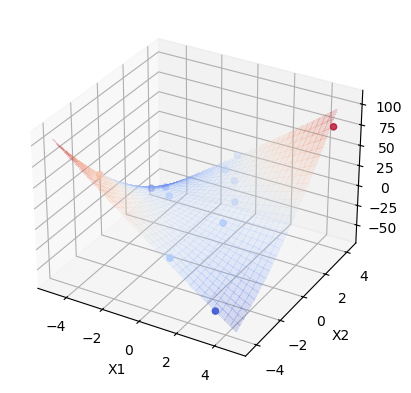

In [7]:
# This is the true unknown function we are trying to approximate
f = lambda x,y: x**2/9 + y**2 + 4*x*y

#This is our dataset
N = 12 #must be even
D = 2 #dimension
X = generate_points(-4, 4, N/2, min_distance = 3, dim = D)
X1 = X[:,0]
X2 = X[:,1]
y = (f(X1,X2) + np.random.normal(0,0,N)).reshape(-1,1) #observations (following true unknown function we wish to approx)

#Function we'd like to estimate --> our goal
rx1, rx2 = np.arange(np.min(X1), np.max(X1), 0.3), np.arange(np.min(X2), np.max(X2), 0.3)
gx1, gx2 = np.meshgrid(rx1, rx2)
x = np.c_[gx1.ravel(), gx2.ravel()]

#Render plots
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(gx1, gx2, f(gx1,gx2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha = 0.2)
ax.scatter(X1,X2,y, c = y, marker = 'o', cmap=cm.coolwarm)

ax.set_xlabel('X1')
ax.set_ylabel('X2')

In [115]:
#Normalize feature:
# X = (X - np.min(X))/(np.max(X) - np.min(X)) #X in [0,1]
# X1 = X[:,0]
# X2 = X[:,1]

#Normalize target:
#y = (y - min(y))/(max(y)-min(y))

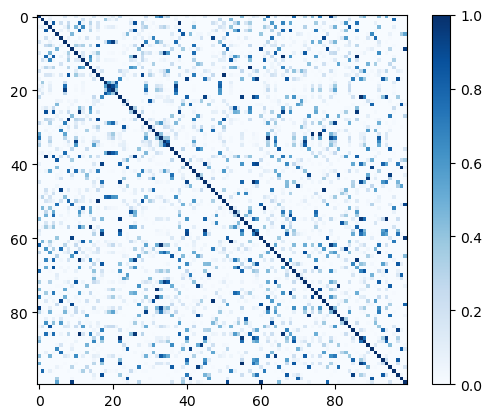

In [8]:
#Plot of kernel
x = np.random.uniform(-4, 4, size=(100,2))
#x = (x - np.min(x))/(np.max(x) - np.min(x)) #X in [0,1]
K = kernel(x, x, 1, 1, 0, 1)

plt.imshow(K, cmap = 'Blues', interpolation = 'nearest')
plt.colorbar()
plt.show()

Text(0.5, 0.5, 'X2')

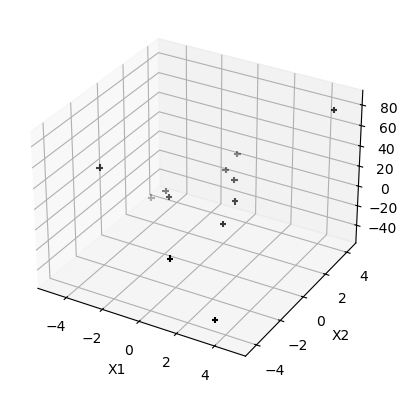

In [9]:
#Render plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(X1,X2,y, marker = '+', color = "black")
ax.set_xlabel('X1')
ax.set_ylabel('X2')

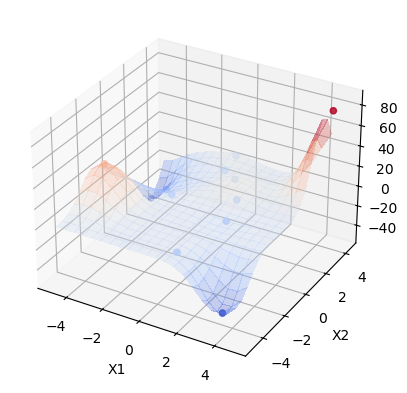

In [10]:
#Plot of GP fit before parameter optimization
plot_2D(X, y, 0.001, 1, 1, 0, 1)

**Choosing initial parameters**

In [44]:
#Initial guesses#
sigma_n = 0 #np.std(y) # guess for observation noise
l1 = 8
l2 = 7
l1l2 = 0.01
sigma = 1000 #(np.abs(np.min(y)) + np.abs(np.max(y)))/2 #this is the semi-range

init_par = [l1, l2, l1l2, sigma_f]
init_par #these are the optimum parameters

[8, 7, 0.01, 1000]

### Marginal likelihood

In [45]:
# Negative Marginal log-likelihood of the GP we would like to optimize
def gp_loss_fn(par, sigma_n, X,y): #input observations (X,y) and initial parameters (guess)
    l1, l2, l1l2, sigma = par #noise std, lengthscale l, and signal std

    N = len(X)
    
    K_y = kernel(X, X, l1, l2, l1l2, sigma) + (sigma_n**2)*np.eye(N)
    K_y_inverse = np.linalg.inv(K_y)
    
    #negative marginal log-likelihood
    mll = (N/2)*np.log(2*np.pi) + (1/2)*np.log(np.linalg.det(K_y)) + (1/2)*np.dot(np.dot(y.T,K_y_inverse),y)
    return mll #this is our objective function

#### Optimization

In [46]:
bnds = ((0.1, 100), (0.1, 100), (0, 100), (0.1, 1000))
opt_par = minimize(gp_loss_fn, init_par, args=(sigma_n, X,y), method="Nelder-Mead", bounds = bnds, options = {'disp':True})
l1, l2, l1l2, sigma = opt_par.x[0], opt_par.x[1], opt_par.x[2], opt_par.x[3]
print("sigma_n, l1, l2, l1l2, sigma = ", sigma_n, l1, l2, l1l2, sigma)

C:\Users\Sasha\AppData\Local\Temp\ipykernel_8356\2834026767.py:11: RuntimeWarning: invalid value encountered in log
  mll = (N/2)*np.log(2*np.pi) + (1/2)*np.log(np.linalg.det(K_y)) + (1/2)*np.dot(np.dot(y.T,K_y_inverse),y)


Optimization terminated successfully.
         Current function value: 42.255919
         Iterations: 370
         Function evaluations: 616
sigma_n, l1, l2, l1l2, sigma =  0 26.526051619240576 22.888080176706353 0.0 1000.0


42.25591928167742


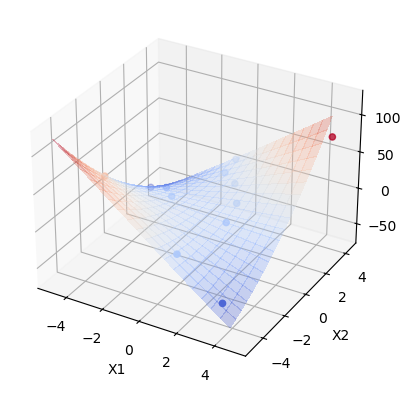

In [47]:
print(gp_loss_fn([l1, l2, l1l2, sigma_f], sigma_n, X,y)[0][0])
plot_2D(X, y, sigma_n, l1, l2, l1l2, sigma)

In [38]:
kernel(X, X, l1, l1, 0, sigma)

array([[1000000.        ,  965734.74464963,  953741.37535634,
         990199.41728362,  985422.00723922,  991352.90701126,
         994342.45606182,  981501.89591676,  990775.96821774,
         997451.51347884,  996186.93576495,  944454.14218583],
       [ 965734.74464963, 1000000.        ,  950711.43171067,
         977255.84147287,  983950.89110869,  951023.64737736,
         962435.21738031,  991209.92531377,  973987.05419558,
         981577.26929146,  940927.95771434,  995226.15395285],
       [ 953741.37535634,  950711.43171067, 1000000.        ,
         923496.12943835,  986021.95655085,  977835.06541754,
         978319.42203019,  980868.06719244,  985097.37774107,
         960769.47088016,  934216.09419823,  956497.20816016],
       [ 990199.41728362,  977255.84147287,  923496.12943835,
        1000000.        ,  973056.6954482 ,  965293.50629217,
         973458.30673521,  975115.88085605,  973319.64063417,
         992945.96282174,  982297.27483998,  953105.80449328],
    

In [39]:
kernel_old(X, X, l1, sigma)

array([[1000000.        ,  965734.74464963,  953741.37535634,
         990199.41728362,  985422.00723922,  991352.90701126,
         994342.45606182,  981501.89591676,  990775.96821774,
         997451.51347884,  996186.93576495,  944454.14218583],
       [ 965734.74464963, 1000000.        ,  950711.43171067,
         977255.84147287,  983950.89110869,  951023.64737736,
         962435.21738031,  991209.92531377,  973987.05419558,
         981577.26929146,  940927.95771434,  995226.15395285],
       [ 953741.37535634,  950711.43171067, 1000000.        ,
         923496.12943835,  986021.95655085,  977835.06541754,
         978319.42203019,  980868.06719244,  985097.37774107,
         960769.47088016,  934216.09419823,  956497.20816016],
       [ 990199.41728362,  977255.84147287,  923496.12943835,
        1000000.        ,  973056.6954482 ,  965293.50629217,
         973458.30673521,  975115.88085605,  973319.64063417,
         992945.96282174,  982297.27483998,  953105.80449328],
    

Sources used:
- http://krasserm.github.io/2018/03/19/gaussian-processes/?utm_source=pocket_saves